In [1]:
import argparse
import numpy as np
import PIL
from PIL import Image, ImageChops
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import copy
import requests
from io import BytesIO
import math
import keyboard
import random
import os
from pathlib import Path

In [2]:
directory = './coco128/images' # директория для поиска имён файлов изображений

# извлечение имён файлов изображений тренировочного набора
train_images = []
for root, dirs, files in os.walk(directory):  
    for filename in files:
        train_images.append(filename)

full_directory = directory + '/train2017/' # директория для извлечения ключевых точек из изображений

In [ ]:
import torch
from PIL import Image
from transformers import CLIPProcessor, CLIPModel

In [7]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch16")

config.json: 100%|██████████| 4.10k/4.10k [00:00<?, ?B/s]
C:\Users\luspa\AppData\Roaming\Python\Python310\site-packages\huggingface_hub\file_download.py:149: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\luspa\.cache\huggingface\hub\models--openai--clip-vit-base-patch16. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
pytorch_model.bin: 100%|██████████

In [8]:
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

tokenizer_config.json: 100%|██████████| 905/905 [00:00<00:00, 301kB/s]
vocab.json: 100%|██████████| 961k/961k [00:00<00:00, 991kB/s]
merges.txt: 100%|██████████| 525k/525k [00:00<00:00, 1.21MB/s]
tokenizer.json: 100%|██████████| 2.22M/2.22M [00:01<00:00, 1.15MB/s]
special_tokens_map.json: 100%|██████████| 389/389 [00:00<?, ?B/s] 


In [84]:
# Представление изображения в виде вектора в метрическом пространстве
def ConvertImageToVector2(path):
    image = Image.open(path)
    # Подготовка изображения для модели CLIP
    inputs = processor(text=None, images=image, return_tensors="pt")
    # Кодирование изображения
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    return image_features
    

In [ ]:
# Представление изображения в виде вектора в метрическом пространстве
def ConvertImageToVector(img):
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    image = Image.fromarray(img_rgb)    
    inputs = processor(text=None, images=image, return_tensors="pt")
    with torch.no_grad():
        image_features = model.get_image_features(**inputs)
    return image_features

In [10]:
# Шаг 5. Создание базы данных
data = pd.DataFrame()
data['index'] = []
data['path_to_img'] = []
data['vector'] = []
data

,index,path_to_img,vector


In [11]:
ind = 0
for path in os.listdir('./VOCdevkit/VOC2012/JPEGImages/'):
    vector = ConvertImageToVector('./VOCdevkit/VOC2012/JPEGImages/' + path)
    new_row = [ind, './VOCdevkit/VOC2012/JPEGImages/' + path, vector]
    data.loc[len(data)] = new_row
    ind += 1

In [32]:
data2 = pd.DataFrame()
data2['index'] = data['index']
data2['path_to_img'] = data['path_to_img']
data2['vector'] = data['vector']

for i in range(len(data2['vector'])):
    ten = data2['vector'][i]
    ten = ten.numpy()
    ten = np.array(ten, np.float64)
    ten = np.round(ten, decimals=10)
    ten = np.array2string(ten, formatter={'float_kind': lambda x: "{:.10f}".format(x)})
    data2['vector'][i] = ten
#ten = data['vector'][0]
#ten = ten.numpy()
#ten = np.array(ten, np.float64)
#ten = np.round(ten, decimals=10)
#ten = np.array2string(ten, formatter={'float_kind': lambda x: "{:.10f}".format(x)})
#ten
##string_values = ten.strip('[]\n').split()

# Преобразование строковых значений в числа с плавающей точкой
#float_values = np.array([float(val) for val in string_values])

#print(float_values)

C:\Users\luspa\AppData\Local\Temp\ipykernel_2512\3186898189.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['vector'][i] = ten
C:\Users\luspa\AppData\Local\Temp\ipykernel_2512\3186898189.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['vector'][i] = ten
C:\Users\luspa\AppData\Local\Temp\ipykernel_2512\3186898189.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data2['vector'][i] = ten
C:\Users\luspa\AppData\Lo

In [35]:
np.set_printoptions(threshold=np.inf)
data2.to_csv('data_full2.csv', index=False, lineterminator='\n')

In [36]:
from sklearn.neighbors import NearestNeighbors

kn_model = NearestNeighbors(n_neighbors=5, metric='cosine')
data3 = pd.read_csv('data_full2.csv')
encoded_data = []
for data_string in data3['vector']:
    string_values = data_string.strip('[]\n').split()
    float_values = np.array([float(val) for val in string_values])
    encoded_data += [float_values]
kn_model.fit(encoded_data)

NearestNeighbors(metric='cosine')

In [92]:
# Поиск k-ближайших соседей для нового входного вектора
cur_path = './VOCdevkit/VOC2012/JPEGImages/2008_000033.jpg'
img = cv2.imread(cur_path)
input_vector = data3.loc[data3['path_to_img'] == cur_path, 'index']
input_vector = data3['vector'].values[input_vector][0]
string_values = input_vector.strip('[]\n').split()
input_vector = np.array([float(val) for val in string_values])

distances, indices = kn_model.kneighbors([input_vector])

In [89]:
data3['path_to_img'][0][-10:]

'000027.jpg'

In [93]:
# Получение путей до изображений по найденным индексам
image_paths = data3['path_to_img']  # список путей до изображений в базе данных
nearest_image_paths = [image_paths[i] for i in indices[0]]
nearest_image_paths

['./VOCdevkit/VOC2012/JPEGImages/2008_000033.jpg',
 './VOCdevkit/VOC2012/JPEGImages/2007_006946.jpg',
 './VOCdevkit/VOC2012/JPEGImages/2008_002719.jpg',
 './VOCdevkit/VOC2012/JPEGImages/2008_002221.jpg',
 './VOCdevkit/VOC2012/JPEGImages/2007_005043.jpg']

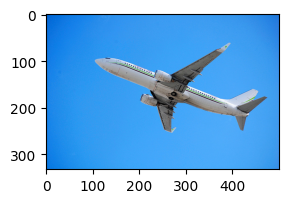

In [94]:
plt.figure(figsize=(3, 4))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

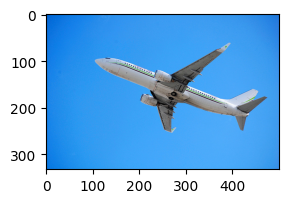

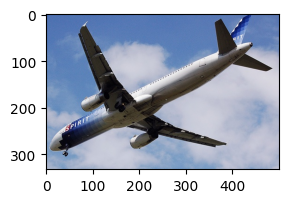

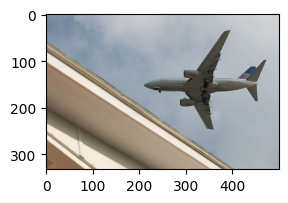

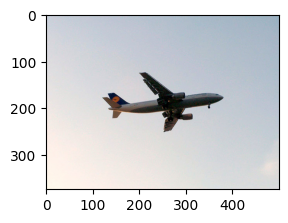

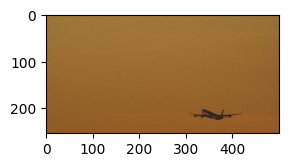

In [95]:
for path in nearest_image_paths:
    image = cv2.imread(path)
    plt.figure(figsize=(3, 4))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))